# Loading Libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
from catboost import Pool, CatBoostClassifier
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler
import os

# Extracting Features from train set

In [6]:
### Read data files train_meta and train

datapath = '/Users/georgyguryev/Documents/repos/6.867/PLAsTiCC-Astronomical-Classification/data'
os.chdir(datapath)
#os.chdir('/Users/shengyao/Downloads/Kaggle Data')


train = pd.read_csv('training_set.csv')
train['flux_ratio_sq'] = np.power(train['flux'] / train['flux_err'], 2.0)
train['flux_by_flux_ratio_sq'] = train['flux'] * train['flux_ratio_sq']

aggs = {
    'mjd': ['min', 'max', 'size'],
    'passband': ['min', 'max', 'mean', 'median', 'std'],
    'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum','skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

agg_train = train.groupby('object_id').agg(aggs)
new_columns = [
    k + '_' + agg for k in aggs.keys() for agg in aggs[k]
]
agg_train.columns = new_columns
agg_train['mjd_diff'] = agg_train['mjd_max'] - agg_train['mjd_min']
agg_train['flux_diff'] = agg_train['flux_max'] - agg_train['flux_min']
agg_train['flux_dif2'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_mean']
agg_train['flux_w_mean'] = agg_train['flux_by_flux_ratio_sq_sum'] / agg_train['flux_ratio_sq_sum']
agg_train['flux_dif3'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_w_mean']

del agg_train['mjd_max'], agg_train['mjd_min']
agg_train.head()

del train

In [7]:
train = pd.read_csv('training_set.csv')

In [8]:
meta_train = pd.read_csv('training_set_metadata.csv')
meta_train.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [6]:
train.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [7]:
agg_train.head()

,mjd_size,passband_min,passband_max,passband_mean,passband_median,passband_std,flux_min,flux_max,flux_mean,flux_median,...,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,mjd_diff,flux_diff,flux_dif2,flux_w_mean,flux_dif3
object_id,,,,,,,,,,,,,,,,,,,,,
615,352,0,5,2.457386,2.0,1.720797,-1100.440063,660.626343,-123.096998,-89.477524,...,0.946023,2.929669e+06,0.812722,-9.601766e+08,-1.414322,873.7903,1761.066406,-14.306331,-327.742307,-5.373326
713,350,0,5,2.400000,2.0,1.746056,-14.735178,14.770886,-1.423351,-0.873033,...,0.171429,5.886068e+03,3.439423,-2.875087e+04,-3.454554,848.8198,29.506064,-20.730002,-4.884564,-6.040676
730,330,0,5,2.336364,2.0,1.758750,-19.159811,47.310059,2.267434,0.409172,...,0.069697,4.124452e+03,5.480405,1.046502e+05,5.989138,853.8455,66.469870,29.315018,25.373110,2.619697
745,351,0,5,2.378917,2.0,1.747328,-15.494463,220.795212,8.909206,1.035895,...,0.173789,9.416165e+04,9.611274,1.439125e+07,11.141069,853.7060,236.289675,26.521968,152.835617,1.546038
1124,352,0,5,2.457386,2.0,1.720797,-16.543753,143.600189,7.145702,1.141288,...,0.173295,3.432418e+04,7.868462,3.015599e+06,7.908174,873.7903,160.143942,22.411225,87.856390,1.822792


# Merging extracted features with meta data

In [8]:
meta_train = pd.read_csv('training_set_metadata.csv')
meta_train.head()

full_train = agg_train.reset_index().merge(
    right=meta_train,
    how='outer',
    on='object_id'
)

if 'target' in full_train:
    y = full_train['target']
    del full_train['target']
classes = sorted(y.unique())

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

print('Unique classes : ', classes)

Unique classes :  [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]


In [9]:
if 'object_id' in full_train:
    oof_df = full_train[['object_id']]
    del full_train['object_id'], full_train['distmod'], full_train['hostgal_specz']
    del full_train['ra'], full_train['decl'], full_train['gal_l'],full_train['gal_b'],full_train['ddf']
    
    
train_mean = full_train.mean(axis=0)
full_train.fillna(train_mean, inplace=True)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Standard Scaling the input (imp.)

In [13]:
full_train_new.shape

(7848, 31)

In [11]:
full_train_new = full_train.copy()
ss = StandardScaler()
full_train_ss = ss.fit_transform(full_train_new)

In [51]:
StandardScaler?

# Deep Learning Begins...

In [14]:
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.utils import to_categorical
import tensorflow as tf
from keras import backend as K
import keras
from keras import regularizers
from collections import Counter
from sklearn.metrics import confusion_matrix

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [15]:
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69795
def mywloss(y_true,y_pred):  
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss

In [16]:
def multi_weighted_logloss(y_ohe, y_p):

    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

# Defining simple model in keras

In [198]:
K.clear_session()
def build_model(dropout_rate=0.25,activation='relu'):
    start_neurons = 512
    # create model
    model = Sequential()
    model.add(Dense(start_neurons, input_dim=full_train_ss.shape[1], activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//2,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//4,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//8,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate/2))
    
    model.add(Dense(len(classes), activation='softmax'))
    return model

In [22]:
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])
y_categorical = to_categorical(y_map)

In [23]:
y_categorical.shape

(7848, 14)

In [24]:
full_train_new.shape

(7848, 31)

# XGBoost

In [25]:
import xgboost as xgb
from sklearn.metrics import precision_score

In [52]:
full_train_ss[500]

array([ 8.04881293e-01,  0.00000000e+00,  0.00000000e+00, -8.85611311e-01,
       -4.70733930e-02, -1.43936648e-02,  3.62848465e-02, -3.70445753e-02,
       -1.11168275e-02,  1.72879929e-02, -6.32930162e-02,  5.21621850e-02,
       -2.88848565e-01, -1.37111508e-02, -2.50976067e-02, -2.13665047e-01,
       -1.59541341e-02,  3.06608140e+00,  2.96105939e-01, -5.02306755e-02,
        1.00414272e-01, -1.24181991e-02,  5.03454864e-01, -9.59729774e-01,
       -3.72334017e-02, -3.07759378e-03, -3.29420204e-02,  2.65357243e-03,
       -1.19857915e-01,  2.86169601e+00, -4.18045012e-01])

In [57]:
d_train = xgb.DMatrix(full_train_new,label=y_categorical)
params = {'eta': 0.1, 'max_depth': 20, 'subsample': 0.9, 'colsample_bytree': 0.9, 
          'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'silent': True, 
          'num_class':14}
nrounds = 100
bst = xgb.train(params, d_train, nrounds,verbose_eval=100)

bst_preds = bst.predict(d_train)


In [58]:
bst_preds = np.asarray([line==np.max(line) for line in bst_preds])
precision_score(y_categorical,bst_preds,average='macro')

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0013743264890053882

In [59]:
xgb.train?

In [32]:
## Decision Tree

In [33]:
from sklearn import tree
tree = tree.DecisionTreeClassifier().fit(full_train_new,y_categorical)
tree_preds = tree.predict(full_train_new)
tree_preds = np.asarray([line==np.max(line) for line in tree_preds])
precision_score(y_categorical,tree_preds,average='macro')

1.0

## Random Forest

In [61]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10,random_state=0).fit(full_train_new,y_categorical)
rf_preds = rf.predict(full_train_new)
rf_preds = np.asarray([line==np.max(line) for line in rf_preds])
precision_score(y_categorical,rf_preds,average='macro')

0.15617530065284962

In [68]:
rf_preds = rf.predict(full_train_new)

In [72]:
full_train_new.head()

,mjd_size,passband_min,passband_max,passband_mean,passband_median,passband_std,flux_min,flux_max,flux_mean,flux_median,...,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,mjd_diff,flux_diff,flux_dif2,flux_w_mean,flux_dif3,hostgal_photoz,hostgal_photoz_err,mwebv
0,352,0,5,2.457386,2.0,1.720797,-1100.440063,660.626343,-123.096998,-89.477524,...,-9.601766e+08,-1.414322,873.7903,1761.066406,-14.306331,-327.742307,-5.373326,0.0000,0.0000,0.017
1,350,0,5,2.400000,2.0,1.746056,-14.735178,14.770886,-1.423351,-0.873033,...,-2.875087e+04,-3.454554,848.8198,29.506064,-20.730002,-4.884564,-6.040676,1.6267,0.2552,0.007
2,330,0,5,2.336364,2.0,1.758750,-19.159811,47.310059,2.267434,0.409172,...,1.046502e+05,5.989138,853.8455,66.469870,29.315018,25.373110,2.619697,0.2262,0.0157,0.021
3,351,0,5,2.378917,2.0,1.747328,-15.494463,220.795212,8.909206,1.035895,...,1.439125e+07,11.141069,853.7060,236.289675,26.521968,152.835617,1.546038,0.2813,1.1523,0.007
4,352,0,5,2.457386,2.0,1.720797,-16.543753,143.600189,7.145702,1.141288,...,3.015599e+06,7.908174,873.7903,160.143942,22.411225,87.856390,1.822792,0.2415,0.0176,0.024


# Calculating the class weights

In [214]:
y_count = Counter(y_map)
wtable = np.zeros((len(unique_y),))
for i in range(len(unique_y)):
    wtable[i] = y_count[i]/y_map.shape[0]

In [215]:
def plot_loss_acc(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('model loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()

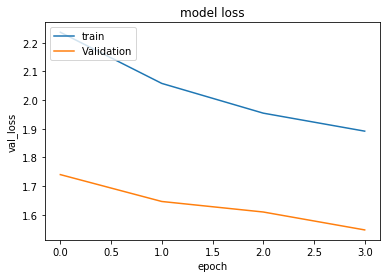

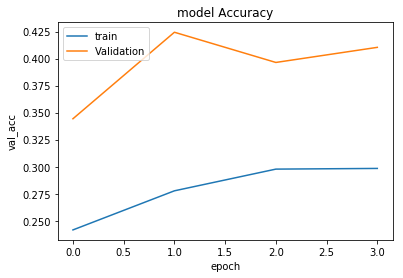

Loading Best Model
1.6143984325167422


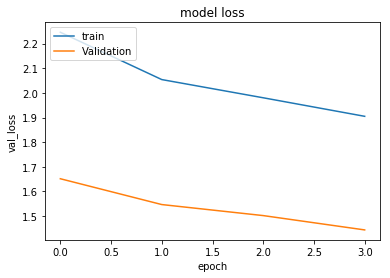

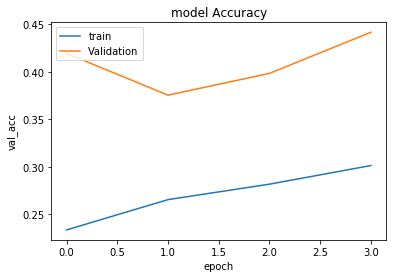

Loading Best Model
1.4473981845473654


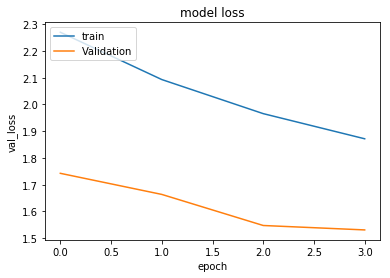

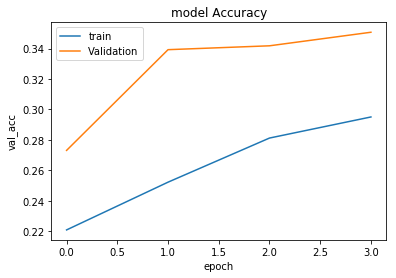

Loading Best Model
1.5447073868166548


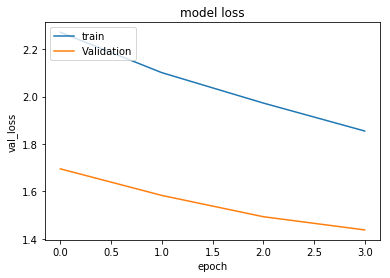

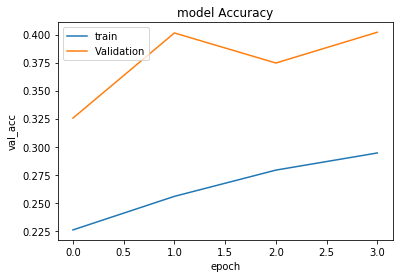

Loading Best Model
1.4852310291829367


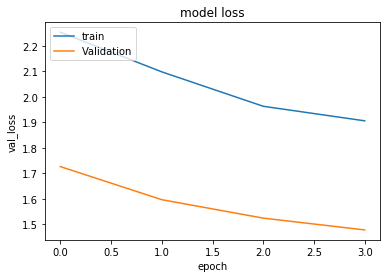

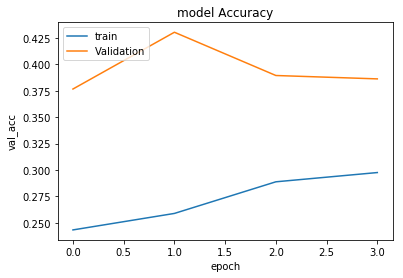

Loading Best Model
1.5192115962402901
MULTI WEIGHTED LOG LOSS : 1.52237 


In [216]:
clfs = []
oof_preds = np.zeros((len(full_train_ss), len(classes)))
epochs = 5
batch_size = 100
for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
    checkPoint = ModelCheckpoint("./keras.model",monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)
    x_train, y_train = full_train_ss[trn_], y_categorical[trn_]
    x_valid, y_valid = full_train_ss[val_], y_categorical[val_]
    
    model = build_model(dropout_rate=0.5,activation='tanh')    
    model.compile(loss=mywloss, optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,shuffle=True,verbose=0,callbacks=[checkPoint])       
    
    plot_loss_acc(history)
    
    print('Loading Best Model')
    model.load_weights('./keras.model')
    # # Get predicted probabilities for each class
    oof_preds[val_, :] = model.predict_proba(x_valid,batch_size=batch_size)
    print(multi_weighted_logloss(y_valid, model.predict_proba(x_valid,batch_size=batch_size)))
    clfs.append(model)
    
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_categorical,oof_preds))

In [217]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [218]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

In [219]:
sample_sub = pd.read_csv('sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()

5805

Normalized confusion matrix
[[0.48 0.   0.08 0.   0.01 0.09 0.   0.07 0.12 0.   0.   0.   0.15 0.  ]
 [0.1  0.26 0.01 0.03 0.05 0.   0.04 0.2  0.03 0.07 0.02 0.06 0.   0.13]
 [0.   0.   0.89 0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.1  0.  ]
 [0.06 0.19 0.01 0.08 0.15 0.   0.06 0.11 0.04 0.05 0.02 0.13 0.01 0.09]
 [0.03 0.19 0.01 0.04 0.22 0.01 0.05 0.11 0.07 0.09 0.   0.14 0.   0.05]
 [0.   0.   0.   0.   0.   0.67 0.   0.   0.   0.   0.   0.   0.3  0.03]
 [0.06 0.17 0.   0.05 0.15 0.   0.07 0.16 0.07 0.08 0.02 0.09 0.   0.07]
 [0.03 0.03 0.01 0.04 0.   0.   0.   0.57 0.21 0.02 0.   0.03 0.   0.07]
 [0.05 0.01 0.05 0.   0.01 0.01 0.   0.2  0.65 0.   0.   0.   0.02 0.  ]
 [0.04 0.13 0.   0.02 0.16 0.   0.05 0.22 0.06 0.13 0.   0.12 0.   0.06]
 [0.   0.   0.02 0.   0.01 0.   0.   0.   0.   0.   0.8  0.   0.05 0.11]
 [0.03 0.19 0.   0.03 0.16 0.   0.02 0.1  0.03 0.1  0.01 0.23 0.   0.09]
 [0.   0.   0.03 0.   0.   0.03 0.   0.   0.   0.   0.01 0.   0.93 0.  ]
 [0.   0.01 0.   0.   0

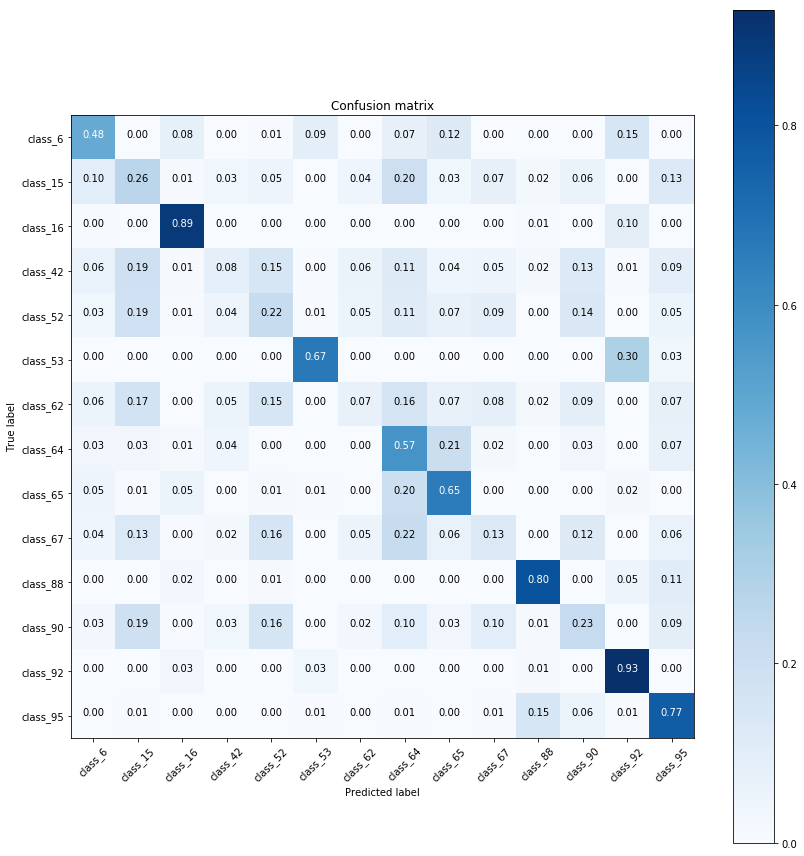

In [220]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')


Normalized confusion matrix
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


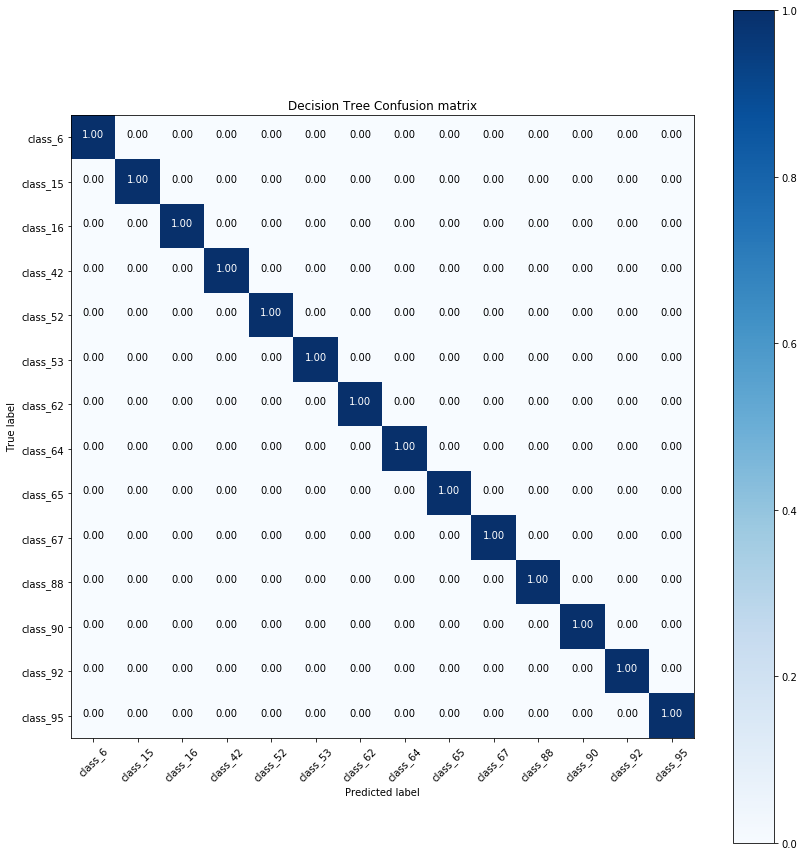

In [221]:
# Compute confusion matrix
tree_matrix = confusion_matrix(y_map, np.argmax(tree_preds,axis=-1))
np.set_printoptions(precision=2)
sample_sub = pd.read_csv('sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()
# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
tree = plot_confusion_matrix(tree_matrix, classes=class_names,normalize=True,
                      title='Decision Tree Confusion matrix')


In [222]:
y_test.shape

(1570, 14)

Normalized confusion matrix
[[0.93 0.   0.05 0.   0.   0.   0.   0.   0.02 0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.22 0.   0.78 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.9  0.   0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.52 0.   0.01 0.   0.   0.   0.   0.   0.47 0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.93 0.   0.07 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0

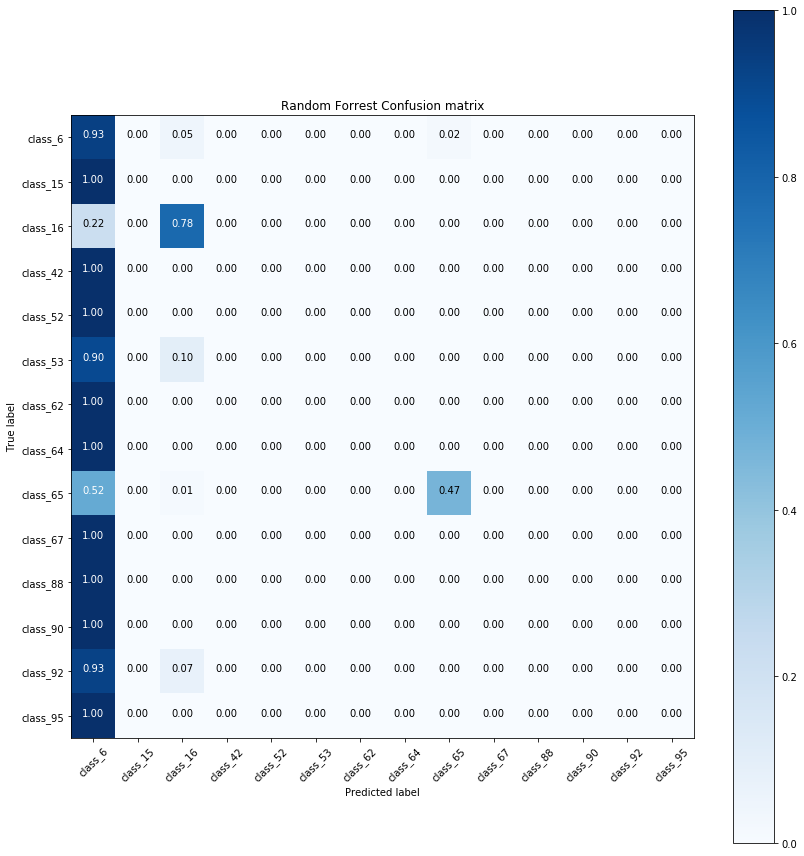

In [224]:
# Compute confusion matrix
rf_matrix = confusion_matrix(y_map, np.argmax(rf_preds,axis=-1))
np.set_printoptions(precision=2)
sample_sub = pd.read_csv('sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()
# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
rf = plot_confusion_matrix(rf_matrix, classes=class_names,normalize=True,
                      title='Random Forrest Confusion matrix')

Normalized confusion matrix
[[9.80e-01 1.99e-02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [9.96e-01 4.04e-03 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [9.92e-01 7.58e-03 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [9.99e-01 8.38e-04 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [9.95e-01 5.46e-03 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [9.67e-01 3.33e-02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [9.94e-01 6.20e-03 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [9.90e-01 9.80e-03 0.00e+00 0.00e+00 0.00e+00 0.00e+00

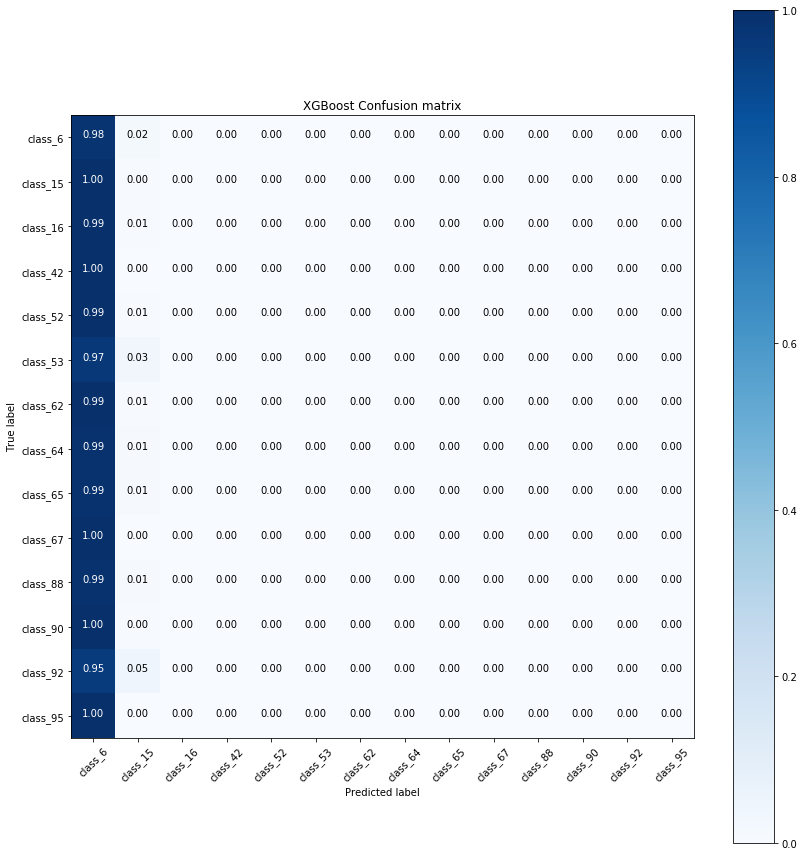

In [225]:
# Compute confusion matrix
bst_matrix = confusion_matrix(y_map, np.argmax(bst_preds,axis=-1))
np.set_printoptions(precision=2)
sample_sub = pd.read_csv('sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()
# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
bst = plot_confusion_matrix(bst_matrix, classes=class_names,normalize=True,
                      title='XGBoost Confusion matrix')

# Test Set Predictions

In [51]:
meta_test = pd.read_csv('/Users/youssefberrada/Downloads/all/test_set_metadata.csv')

import time

start = time.time()
chunks = 5000000
for i_c, df in enumerate(pd.read_csv('/Users/youssefberrada/Downloads/all/test_set.csv', chunksize=chunks, iterator=True)):
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    # Group by object id
    agg_test = df.groupby('object_id').agg(aggs)
    agg_test.columns = new_columns
    agg_test['mjd_diff'] = agg_test['mjd_max'] - agg_test['mjd_min']
    agg_test['flux_diff'] = agg_test['flux_max'] - agg_test['flux_min']
    agg_test['flux_dif2'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_mean']
    agg_test['flux_w_mean'] = agg_test['flux_by_flux_ratio_sq_sum'] / agg_test['flux_ratio_sq_sum']
    agg_test['flux_dif3'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_w_mean']

    del agg_test['mjd_max'], agg_test['mjd_min']
#     del df
#     gc.collect()
    
    # Merge with meta data
    full_test = agg_test.reset_index().merge(
        right=meta_test,
        how='left',
        on='object_id'
    )
    full_test[full_train.columns] = full_test[full_train.columns].fillna(train_mean)
    full_test_ss = ss.transform(full_test[full_train.columns])
    # Make predictions
    preds = None
    for clf in clfs:
        if preds is None:
            preds = clf.predict_proba(full_test_ss) / folds.n_splits
        else:
            preds += clf.predict_proba(full_test_ss) / folds.n_splits
    
   # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds.shape[0])
    for i in range(preds.shape[1]):
        preds_99 *= (1 - preds[:, i])
    
    # Store predictions
    preds_df = pd.DataFrame(preds, columns=class_names)
    preds_df['object_id'] = full_test['object_id']
    preds_df['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 
    
    if i_c == 0:
        preds_df.to_csv('/Users/youssefberrada/Downloads/all/predictions.csv',  header=True, mode='a', index=False)
    else: 
        preds_df.to_csv('/Users/youssefberrada/Downloads/all/predictions.csv',  header=False, mode='a', index=False)
        
    del agg_test, full_test, preds_df, preds
#     print('done')
    if (i_c + 1) % 10 == 0:
        print('%15d done in %5.1f' % (chunks * (i_c + 1), (time.time() - start) / 60))

       50000000 done in   7.6
      100000000 done in  15.6
      150000000 done in  23.8
      200000000 done in  32.2
      250000000 done in  40.4
      300000000 done in  48.8
      350000000 done in  57.6
      400000000 done in  66.2
      450000000 done in  74.4


In [52]:
z = pd.read_csv('/Users/youssefberrada/Downloads/all/predictions.csv')

print(z.groupby('object_id').size().max())
print((z.groupby('object_id').size() > 1).sum())

z = z.groupby('object_id').mean()

z.to_csv('/Users/youssefberrada/Downloads/all/single_predictions.csv', index=True)

2
88


In [53]:
z.head()

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
object_id,,,,,,,,,,,,,,,
13,0.008352,0.006259,0.016993,0.109872,0.257811,0.010307,0.137079,0.006545,0.012456,0.071138,0.065933,0.176401,0.011654,0.109199,0.145436
14,0.002049,0.005784,0.006705,0.049627,0.156428,0.009774,0.067542,0.019151,0.029425,0.151594,0.035205,0.362418,0.010190,0.094107,0.140116
17,0.001011,0.007374,0.004443,0.052500,0.132025,0.007932,0.066525,0.009760,0.006673,0.134692,0.070721,0.320009,0.005601,0.180733,0.142032
23,0.001185,0.007416,0.002486,0.067904,0.163139,0.004681,0.101696,0.010819,0.007381,0.152186,0.036220,0.327018,0.004007,0.113862,0.141701
34,0.006786,0.005238,0.002138,0.048591,0.145823,0.005774,0.093369,0.016430,0.057555,0.233367,0.009391,0.296036,0.004637,0.074865,0.142088


In [74]:
def plot_model_in_notebook(model):
    return SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

plot_model_in_notebook(model)

NameError: name 'model' is not defined